In [12]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNNr
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
# MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# MODEL_PATH = os.path.join(ROOT_DIR, r"logs\train_003_24_m351_with_tensorboard_wrong\mask_rcnn_occlusion_0024.h5")
MODEL_PATH = r"D:\Desktop\FYP - Robust Surgical Tool Detection and Occlusion Handling using Deep Learning\Mask_RCNN-Occulusion\logs\train_004_120_m351\mask_rcnn_occlusion_0120.h5"

## Configuration

In [15]:
import occlusion
config = occlusion.OcclusionConfig()
dataset_DIR = '../../datasets/dataset_occluded'

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

# config.NUM_CLASSES -= 1
# config.__init__()

config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preference

In [29]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Dataset

In [23]:
# Build validation dataset
dataset = occlusion.OcclusionDataset()
dataset.load_occlusion(dataset_DIR, "test")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Images: 40
Classes: ['BG', 'aeroplane', 'bottle', 'bus', 'car', 'train']


## Display gt

image ID: occlusion.trainFGL1_BGL1/n02917067_1701 (0) trainFGL1_BGL1/n02917067_1701


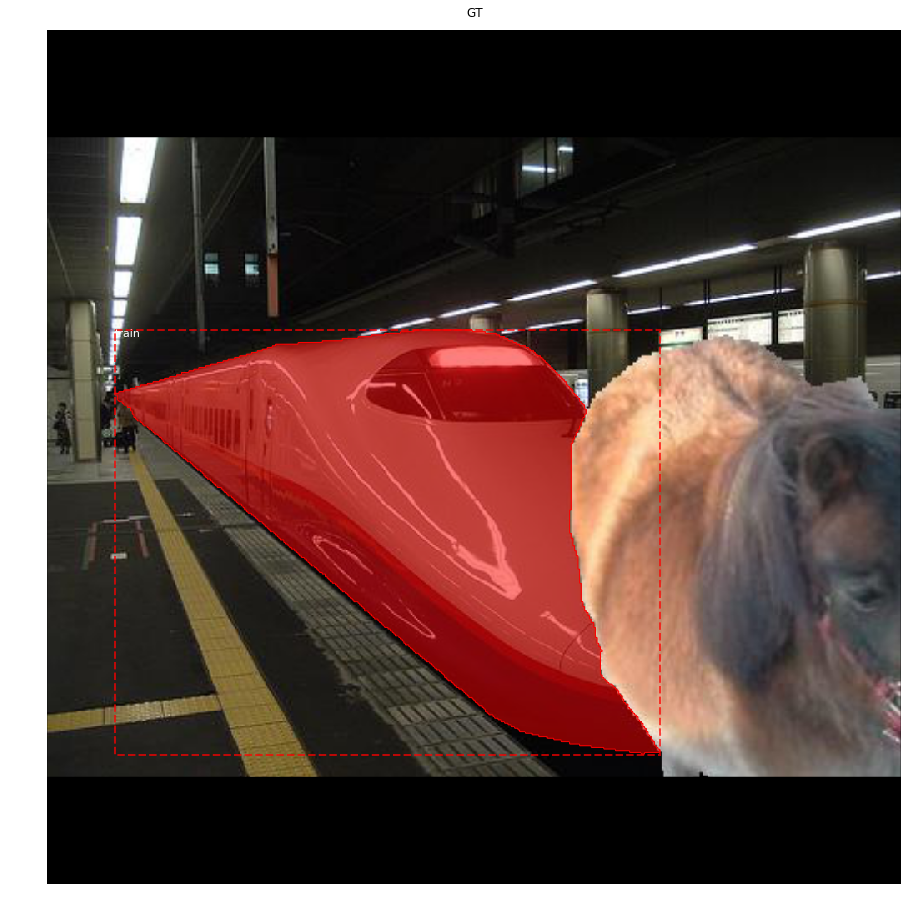

In [25]:
%matplotlib inline
image_id = 0
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
                                       dataset.image_reference(image_id)))
visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id,
                            dataset.class_names, title="GT")


# annos = dataset.image_info[image_id]['annotations'][0]

# polygons = annos['segmentation'][0]

# polygons = np.array(polygons).reshape(-1, 2)

# # Define the resize factor
# resize_factor_height = 800/info['height']
# resize_factor_width = 1024/info['width']

# # Scale the polygon coordinates to match the resized image
# resized_mask_coords = []
# for coord in polygons:
#     x = int(coord[0] * resize_factor_width)
#     y = int(coord[1] * resize_factor_height) + (1024-800)/2
#     resized_mask_coords.append((x, y))

# # Create a figure and axis object
# _, ax = plt.subplots(1, figsize=(16, 16))

# # Plot the resized image
# ax.imshow(image)

# xs, ys = zip(*resized_mask_coords)
# ax.scatter(xs, ys, c='r')



## Display gt polygon

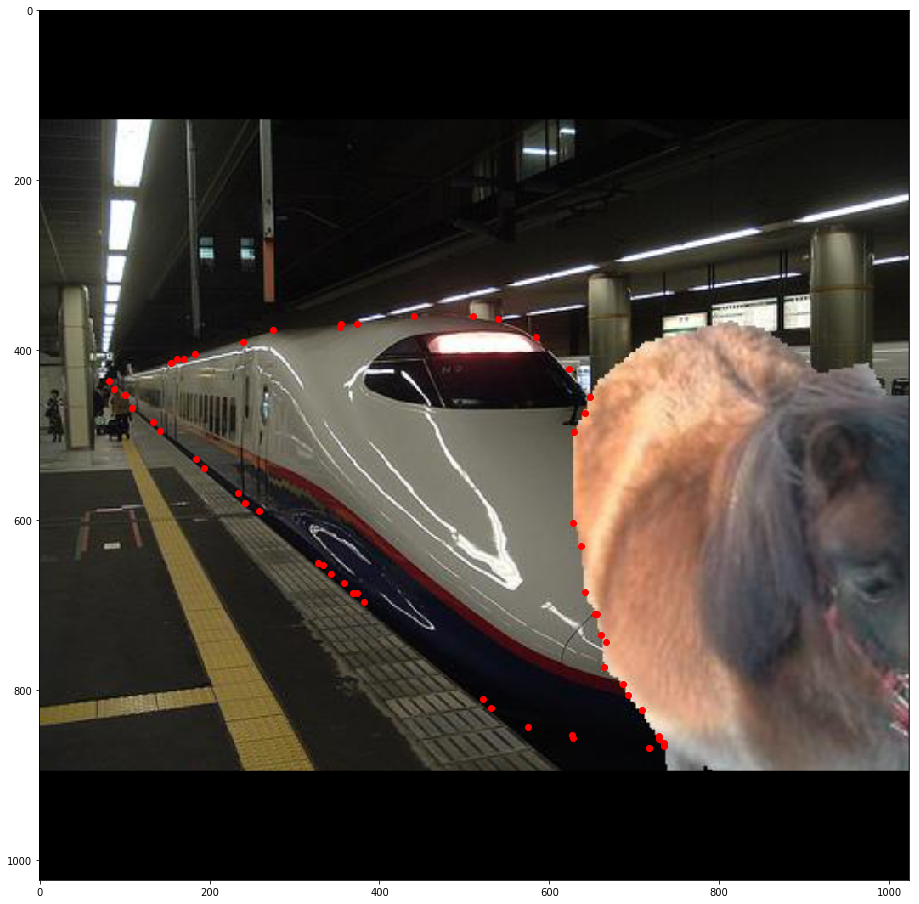

In [26]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon
from pycococreatortools.pycococreatortools import binary_mask_to_polygon

# Create a figure and axis object
_, ax = plt.subplots(1, figsize=(16, 16))

# Plot the resized image
ax.imshow(image)

mask = gt_mask[:, :, 0]
# Mask Polygon
# Pad to ensure proper polygons for masks that touch image edges.
padded_mask = np.zeros(
    (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
padded_mask[1:-1, 1:-1] = mask

contours = binary_mask_to_polygon(padded_mask, tolerance=2)
# contours = find_contours(padded_mask, 0.5)
# for verts in contours:
#     # Subtract the padding and flip (y, x) to (x, y)
#     verts = np.fliplr(verts) - 1
#     p = Polygon(verts, facecolor="none", linewidth=2, edgecolor='r')
#     # ax.add_patch(p)
#     xs, ys = zip(*verts)
#     ax.scatter(xs, ys, c='r')

polygons = np.array(contours).reshape(-1, 2)

xs, ys = zip(*polygons)
ax.scatter(xs, ys, c='r')

## Load Model

In [27]:
# Make preiction
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
weights_path = MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  D:\Desktop\FYP - Robust Surgical Tool Detection and Occlusion Handling using Deep Learning\Mask_RCNN-Occulusion\logs\train_004_120_m351\mask_rcnn_occlusion_0120.h5








## Run detection

image ID: occlusion.trainFGL1_BGL1/n02917067_1701 (0) trainFGL1_BGL1/n02917067_1701
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    5.00000  max:    5.00000  int32
gt_bbox                  shape: (1, 4)                min:   81.00000  max:  868.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


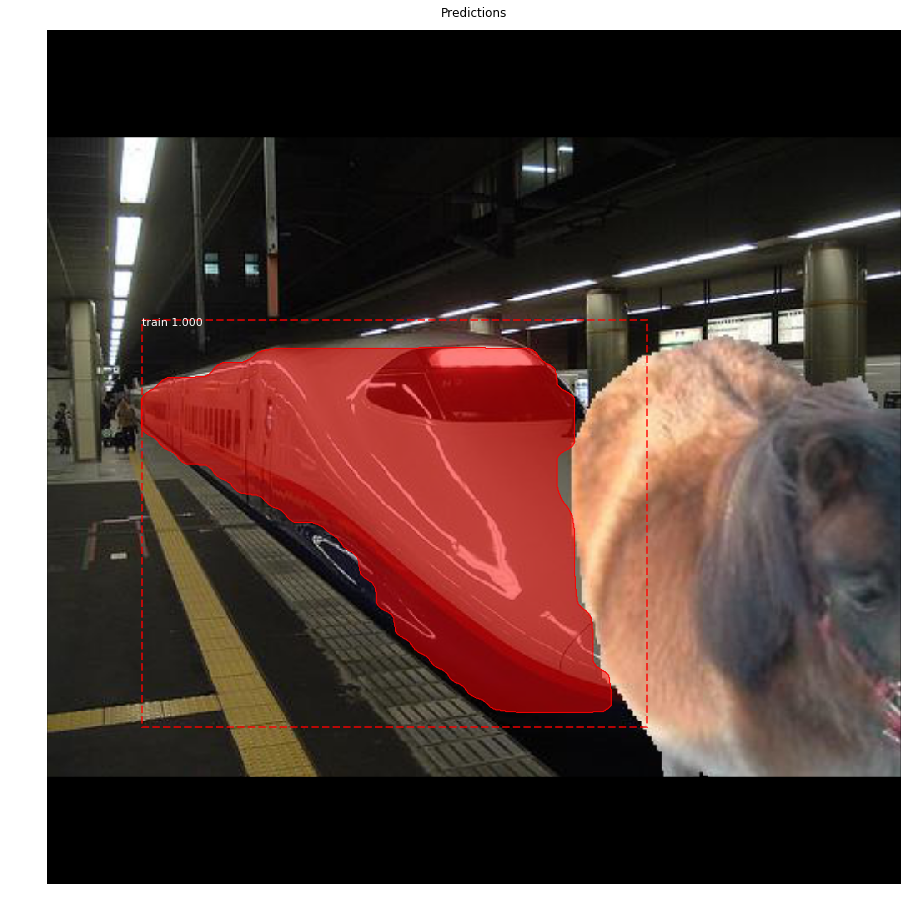

In [30]:
image_id = 0
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Display predicted mask polyton


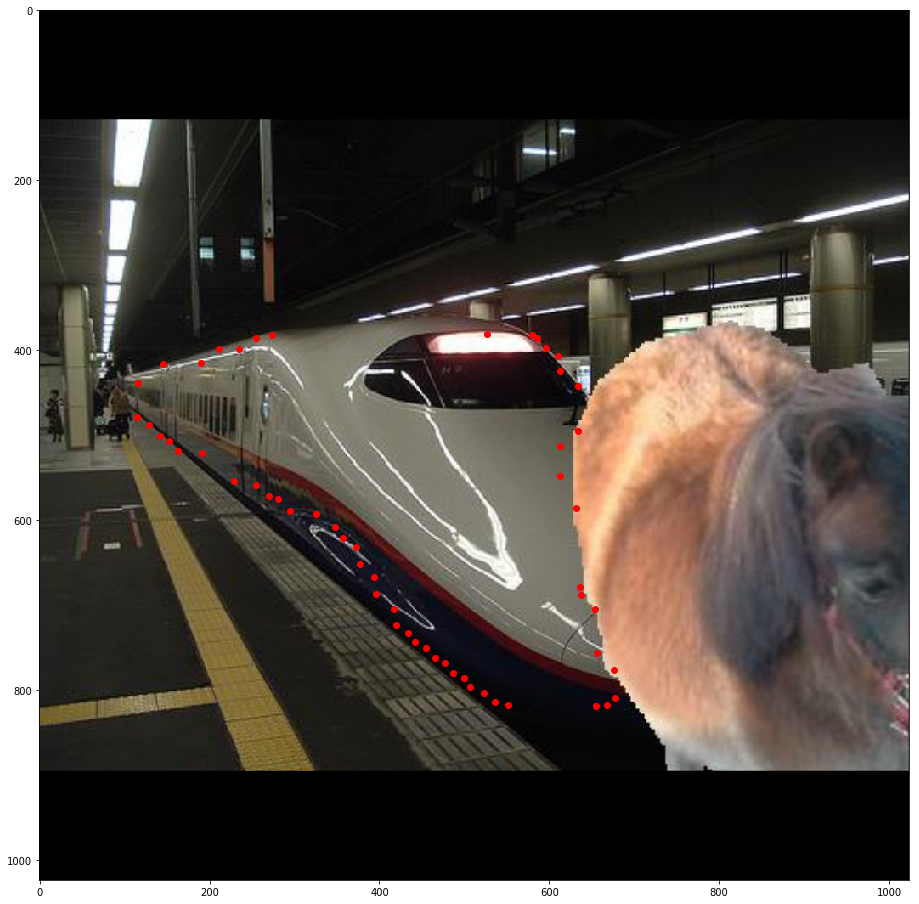

In [32]:
# Create a figure and axis object
_, ax = plt.subplots(1, figsize=(16, 16))

ax.imshow(image)

mask = r['masks'][:, :, 0]
padded_mask = np.zeros(
    (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
padded_mask[1:-1, 1:-1] = mask

contours = binary_mask_to_polygon(padded_mask, tolerance=2)

polygons = np.array(contours).reshape(-1, 2)

xs, ys = zip(*polygons)
ax.scatter(xs, ys, c='r')